<a href="https://colab.research.google.com/github/salty-vanilla/keras-gans/blob/master/wgan_gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras
from keras import Sequential, Model
from keras.layers import Dense, Conv2D, Conv2DTranspose, BatchNormalization, Reshape, Flatten, Input, Dropout, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.datasets import mnist, fashion_mnist
import keras.backend as K
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [0]:
image_shape = (28, 28, 1)

## ハイパーパラメータの設定
* GANはハイパーパラメータ調整に非常に敏感です
* 学習係数を変更することで，大きく学習結果が変わります


In [0]:
latent_dim = 100
epochs = 10
batch_size = 100
lr_g = 1e-4
lr_d = 5e-4
beta_1 = 0.5
beta_2 = 0.99

## Generatorの構築
* 今回はMNISTを学習するため，目標サイズは(28, 28, 1)
* `latent_dim` 次元のベクトルに全結合 ＋ 3回のUpsampling
* 最後の活性化関数を`tanh`にするのが慣習

In [0]:
generator = Sequential([
    Dense(3*3*256, input_dim=latent_dim),
    Reshape((3, 3, 256)),
    BatchNormalization(),
    Activation('relu'),

    
    Conv2DTranspose(128, 5, strides=1, padding='valid',
                    kernel_initializer='glorot_normal'),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2DTranspose(64, 5, strides=2, padding='same',
                    kernel_initializer='glorot_normal'),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2DTranspose(1, 5, strides=2, padding='same',
                    kernel_initializer='glorot_normal'),
    Activation('tanh')
])
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2304)              232704    
_________________________________________________________________
reshape_2 (Reshape)          (None, 3, 3, 256)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 3, 3, 256)         1024      
_________________________________________________________________
activation_5 (Activation)    (None, 3, 3, 256)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 7, 7, 128)         819328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
activation_6 (Activation)    (None, 7, 7, 128)         0         
__________

## Discriminatorの構築
* (28, 28, 1)から1次元のベクトルを出力
* 出力にsigmoidをかけない

In [0]:
discriminator_seq = Sequential([
    Conv2D(32, 3, padding='same', strides=2,
           input_shape=image_shape),
    LeakyReLU(0.2),

    Conv2D(64, 3, padding='same', strides=2),
    LeakyReLU(0.2),

    Conv2D(128, 3, padding='same', strides=2),
    LeakyReLU(0.2),
    
    Conv2D(256, 3, padding='same', strides=2),
    LeakyReLU(0.2),

    Flatten(),
    Dense(1, activation=None)
])
fake_input = Input(shape=image_shape)
discriminator = Model(inputs=[discriminator_seq.input, fake_input],
                      outputs=[discriminator_seq.output, fake_input])
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_5_input (InputLayer)     (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 14, 14, 32)   320         conv2d_5_input[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 14, 14, 32)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 7, 7, 64)     18496       leaky_re_lu_5[0][0]              
__________________________________________________________________________________________________
leaky_re_l

## Loss関数を設計

In [0]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true*y_pred)

### Gradient Penaltyの定義


In [0]:
def gradient_penalty(y_true, y_pred):
    real = y_true
    fake = y_pred
    eps = K.random_uniform(shape=(2*batch_size, 1, 1, 1))
    differences = fake - real
    interpolates = real + (eps*differences)
    grads = K.gradients(discriminator_seq(interpolates), [interpolates])[0]
    slopes = K.sqrt(K.sum(K.square(grads), [1, 2, 3]))
    return 10. * K.mean(K.square(slopes - 1.))

## Discriminatorのビルド
* Loss関数はWasserstein Distance + Gradient Penalty

In [0]:
discriminator.compile(
    optimizer=Adam(lr=lr_d, 
                   beta_1=beta_1,
                   beta_2=beta_2),
    loss=[wasserstein_loss, gradient_penalty])

**ここで，`trainable` を `False`にする**   
これにより，Generatorを更新する際にDiscriminatorのパラメータも一緒に更新されてしまうのを防ぐ

In [0]:
discriminator.trainable = False
discriminator_seq.trainable = False

## Generator  + Discriminator のビルド
* ただし，Discriminatorはfixされている
* Loss関数は同じくBCE

In [0]:
latent = Input(shape=(latent_dim, ))
combined = Sequential([generator, discriminator_seq])
combined.compile(
    optimizer=Adam(lr=lr_g, 
                   beta_1=beta_1,
                   beta_2=beta_2),
    loss=wasserstein_loss)

## MNISTの準備
* Generatorの最後の活性化関数に合わせて，[-1, 1]に正規化

In [0]:
# MNIST
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# Fashoin MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1)

x_test = (x_test.astype(np.float32) - 127.5) / 127.5
x_test = np.expand_dims(x_test, axis=-1)

nb_train, nb_test = x_train.shape[0], x_test.shape[0]

df = pd.DataFrame({'disc_loss': [],
                   'gen_loss': []})

In [0]:
# 1epoch に何回パラメータの更新があるか計算
steps_per_epoch = nb_train // batch_size
if nb_train % batch_size != 0:
    steps_per_epoch += 1

## ここからFitループ


In [0]:
for epoch in range(1, epochs+1):
    print('Epoch %d/%d' % (epoch, epochs), end='\t')
    sum_disc_loss = 0
    sum_gen_loss = 0
    for iter_ in range(steps_per_epoch):
        # 画像バッチとノイズバッチの用意
        image_batch = x_train[iter_*batch_size: (iter_+1)*batch_size]
        noise = np.random.uniform(-1, 1, (len(image_batch), latent_dim))
        
        if len(image_batch) != batch_size:
            continue
        
        # fakeを生成
        generated_images = generator.predict(noise)
        
        # discriminator更新用にデータをconcat
        x = np.concatenate((image_batch, generated_images))
        x_ = np.concatenate((generated_images, image_batch))
        y = np.array([-1]*len(image_batch) + [1]*len(noise))

        # discriminatorの更新
        disc_loss = discriminator.train_on_batch([x, x_],
                                                 [y, x])
        sum_disc_loss += disc_loss[0]

        # generatorの更新
        y = [-1]*len(noise)
        gen_loss = combined.train_on_batch(noise, y)
        sum_gen_loss += gen_loss
        
        df = df.append(pd.Series({'disc_loss': disc_loss[0],
                                  'gen_loss': gen_loss}),
                       ignore_index=True)
    
    print('disc_loss: %.4f  gen_loss: %.4f' % (sum_disc_loss/steps_per_epoch,
                                               sum_gen_loss/steps_per_epoch))
   
    # 生成画像を整形して保存
    vis_col = vis_row = int(np.sqrt(batch_size))
    h, w, _ = image_shape
    generated_images = generated_images[:vis_col*vis_row]
    generated_images = ((generated_images + 1) * 127.5).astype('uint8')
    generated_images = generated_images.reshape(vis_row, vis_col, h, w)
    generated_images = generated_images.transpose(0, 2, 1, 3)
    generated_images = generated_images.reshape(vis_row*h, vis_col*w)
    Image.fromarray(generated_images).save('epoch_%d.png' % epoch)


Epoch 1/10	

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


disc_loss: -3.2524  gen_loss: -15.9687
Epoch 2/10	disc_loss: -1.3046  gen_loss: -23.0588
Epoch 3/10	disc_loss: -0.9923  gen_loss: -22.9050
Epoch 4/10	disc_loss: -0.8361  gen_loss: -18.0467
Epoch 5/10	disc_loss: -0.7078  gen_loss: -14.2917
Epoch 6/10	disc_loss: -0.5990  gen_loss: -11.3452
Epoch 7/10	disc_loss: -0.5254  gen_loss: -9.6144
Epoch 8/10	disc_loss: -0.5003  gen_loss: -8.2088
Epoch 9/10	disc_loss: -0.4878  gen_loss: -7.2126
Epoch 10/10	disc_loss: -0.4489  gen_loss: -6.6118


## 生成した画像を見てみる

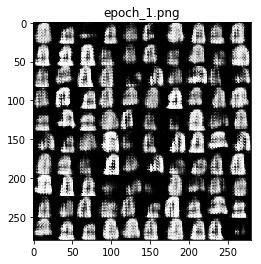

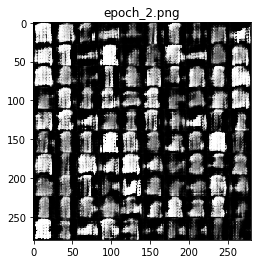

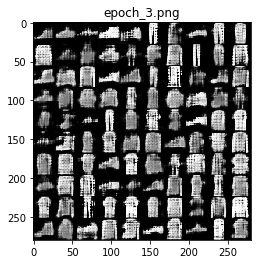

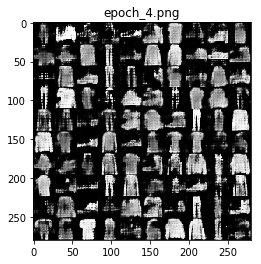

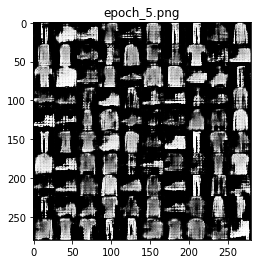

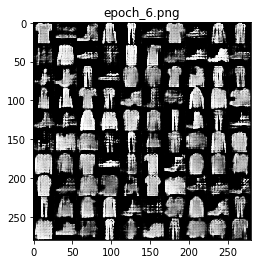

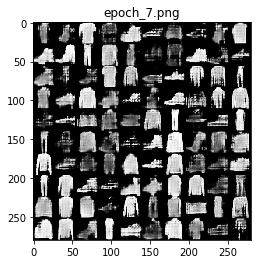

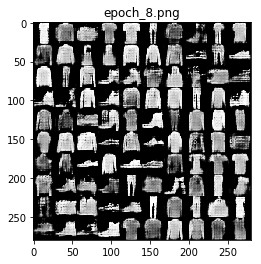

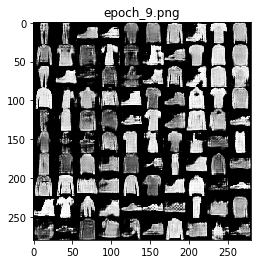

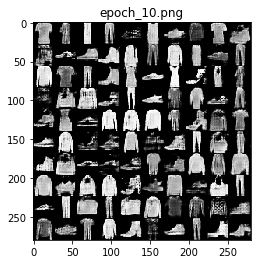

In [0]:
for e in range(1, epochs+1):
    plt.figure()
    im = Image.open('epoch_%d.png' % e)
    plt.imshow(im, cmap='gray')
    plt.title('epoch_%d.png' % e)

## Lossの推移を見てみる

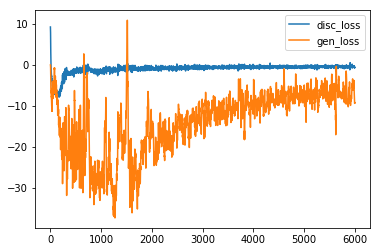

In [0]:
df = df.astype(float)
df['disc_loss'].plot()
df['gen_loss'].plot()
plt.legend()